# Tarea 3 Machine Learning - Métodos no Lineales

Juan Pablo Muñoz - 201373522-3

Margarita Bugueño Pérez - 201373510-K

## 2. Bike Sharing: Predicción de Demanda Horaria

En esta parte, se simula la participación en el desafío *Bike Sharing Demand* de *Kaggle*. El objetivo, es obtener un puntaje igual o menor a $0.37748$. La función de puntaje a utilizar es la siguiente:

\begin{equation}
E_{bikes}(y,\hat{y}) = \frac{1}{n} \sum_i (\ln(y_i + 1) - \ln(\hat{y}_i + 1))^2
\end{equation}

Donde $y, \hat{y} \in \mathbb{R}^n$ son los vectores de observaciones y predicciones, respectivamente. Notar que esta métrica de puntaje se basa en una medida de *distancia* entre lo predicho y lo esperado, por lo que, entre menor sea el valor del puntaje, mejor éste será, ya que $y$ e $\hat{y}$ están más cercanos entre sí.

La descripción del dataset a utilizar es la siguiente.

| Atributo   | Descripción                                                                            |
|------------|----------------------------------------------------------------------------------------|
| datetime   | Hora del día + *timestamp*                                                             |
| season     | 1 = primavera                                                                          |
|            | 2 = verano                                                                             |
|            | 3 = otoño                                                                              |
|            | 4 = invierno                                                                           |
| holiday    | Si el día es considerado feriado                                                       |
| workingday | Si el día no es ni fin de semana ni feriado                                            |
| weather    | 1: Despejado, Nubosidad leve, Parcialmente nublado                                     |
|            | 2: Niebla+Nublado, Niebla+Nubosidad Parcial, Niebla+Nubosidad leve, Niebla             |
|            | 3: Nieve ligera, Lluvia ligera+Relámpagos+Nubosidad leve, Lluvia ligera+Nubosidad leve |
|            | 4: Lluvia fuerte+Granizo+Relámpagos+Niebla, Nieve+Niebla                               |
| temp       | Temperatura en ºC                                                                      |
| atemp      | Sensación térmica en ºC                                                                |
| humidity   | Humedad relativa                                                                       |
| windspeed  | Velocidad del viento                                                                   |
| casual     | Número de rentas hechas por usuarios no registrados en el día                          |
| registered | Número de rentas hechas por usuarios registrados en el día                             |
| count      | Total de rentas realizadas en el día                                                   |

#### (a) Cargar los datos de entrenamiento, validación y pruebas en *dataframes* y extracción de atributo *hour* desde el timestamp del atributo *datetime*.

In [1]:
import pandas as pd
import numpy as np

dftrain = pd.read_csv('bike_sharing_train.csv')
dfval = pd.read_csv('bike_sharing_val.csv')
dftest = pd.read_csv('bike_sharing_test.csv')
ntrain = len(dftrain)
nval = len(dftrain) + len(dfval)
df = pd.concat([dftrain,dfval,dftest])
print ('\nSummary - dataframe completo:\n')
print (df.describe())
df['hour'] = pd.to_datetime(df['datetime']).apply(lambda x: x.strftime('%H'))
df['hour'] = pd.to_numeric(df['hour'])


Summary - dataframe completo:

         Unnamed: 0        season       holiday    workingday       weather  \
count  10886.000000  10886.000000  10886.000000  10886.000000  10886.000000   
mean    5442.500000      2.506614      0.028569      0.680875      1.418427   
std     3142.661849      1.116174      0.166599      0.466159      0.633839   
min        0.000000      1.000000      0.000000      0.000000      1.000000   
25%     2721.250000      2.000000      0.000000      0.000000      1.000000   
50%     5442.500000      3.000000      0.000000      1.000000      1.000000   
75%     8163.750000      4.000000      0.000000      1.000000      2.000000   
max    10885.000000      4.000000      1.000000      1.000000      4.000000   

              temp         atemp      humidity     windspeed        casual  \
count  10886.00000  10886.000000  10886.000000  10886.000000  10886.000000   
mean      20.23086     23.655084     61.886460     12.799395     36.021955   
std        7.79159    

Antes de analizar el dataframe, se nota que existe una columna sin identificar, llamada `Unnamed: 0`. Esta corresponde al número de registro, y no cumple con entregar información relevante sobre el problema abordado, por lo que será eliminada. También, la columna `datetime` no aparece en la descripción del dataframe, ya que al ser de tipo `string`, no se le puede calcular estadísticos.

In [38]:
df=df.drop(['Unnamed: 0'], axis=1)

In [39]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000


El parámetro `season` es de tipo categórico. Es decir que, la relación entre los posibles valores (1, 2, 3, 4) no es de orden entre ellos, sino de pertenencia a distintas *clases*. Otro parámetro con esta característica es `weather`. Se puede visualizar la distribución de estos datos (de entrenamiento, validación y prueba combinados) a través de histogramas.

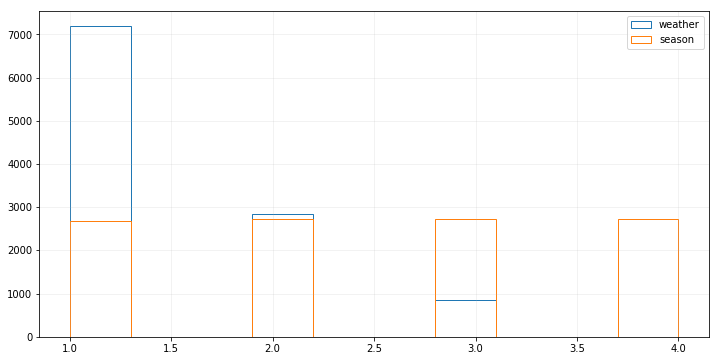

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.grid(alpha=0.2)
plt.hist(df['weather'], histtype='step', label='weather')
plt.hist(df['season'], histtype='step', label='season')
plt.legend(loc='upper right')
plt.show()

Observar que, la cantidad de registros por estación del año (naranjo) es prácticamente constante, ubicándose  al rededor de los 2600 para primavera (1), verano (2), otoño (3) e invierno (4). En cambio, la cantidad de registros difiere bastante dependiendo del tiempo actual: hay más de 7000 registros de rentas en días soleados o levemente despejados (1), al rededor de 2900 en días nublados o con neblina (2), unos 900 en días con precipitaciones de agua o nieve (3), y ninguna en los días de tormenta eléctrica o con granizos y niebla (4).

Notar que los registros no son instancias de arriendos, sino que reportan la cantidad de arriendos en la ventana de tiempo entre el *datetime* actual y el del anterior registro. Por lo tanto, se puede concluir que cuando `weather=4`, el servicio de arriendo no estuvo disponible (quizás por razones de seguridad), pues no se hicieron registros, y no porque no haya habido arriendos.

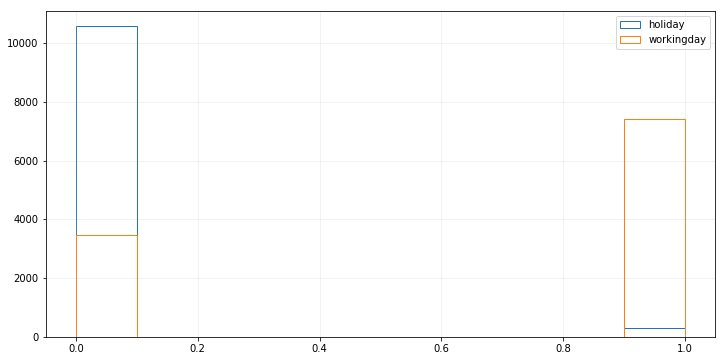

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.grid(alpha=0.2)
plt.hist(df['holiday'], histtype='step', label='holiday')
plt.hist(df['workingday'], histtype='step', label='workingday')
plt.legend(loc='upper right')
plt.show()

Otro tipo de atributo son los binarios, y los atributos `holiday` y `workingday` corresponden a esta categoría. Del histograma anterior, se nota que `holiday` (azul) es 0 para casi todos los registros, lo que tiene sentido, pues estadísticamente, los días feriados son pocos durante el año. En el caso de `workingday`, se nota que hay aproximadamente 3600 registros en los que este parámetro es 0, y 1 en el resto (unos 7500 registros). Por lo tanto, la mayoría de los registros se hicieron en días hábiles de la semana y no feriados.

Luego, los atributos `temp`, `atemp`, `humidity`, y `windspeed` son atributos de naturaleza continua, y son los que sólo requieren del preprocesado de escalado y centrado para poder ser procesados correctamente por los modelos estudiados hasta ahora. `temp` y `atemp` se mueven aproximadamente entre los valores 0 y 45. `humidity` es un porcentaje, por lo que varía entre 0 y 100. `windspeed` varía entre 0 y 57 aproximadamente.

Siguen los atributos `casual`, `registered` y `count`, que son discretos y contables. En este caso, dada su gran variabilidad entre registros (entre 0 y 980, aproximadamente), es conveniente considerarlos como continuos.

El último atributo agregado es `hour`, y su valor va desde 0 a 24. Podemos observar las horas en que más arriendos se producen.

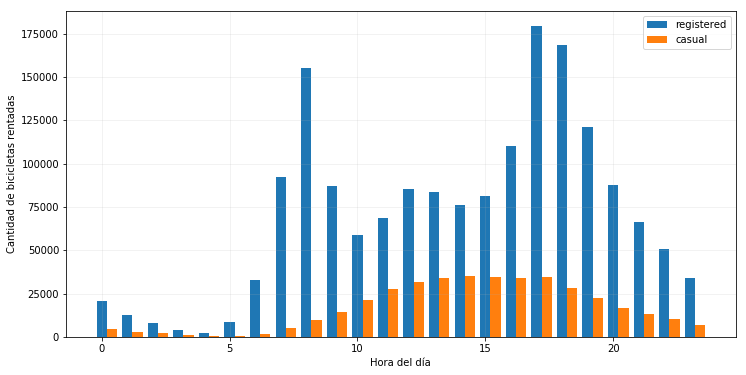

In [76]:
casual = [0]*24
registered = [0]*24

for registro in df.as_matrix():
    casual[registro[-1]] += registro[-4]
    registered[registro[-1]] += registro[-3]

f, ax = plt.subplots(figsize=(12,6))
ax.grid(alpha=0.2)
ax.bar(np.arange(24),registered, 0.4, label='registered')
ax.bar(np.arange(24)+0.4,casual, 0.4, label='casual')
ax.legend(loc='upper right')
ax.set_xlabel('Hora del día')
ax.set_ylabel('Cantidad de bicicletas rentadas')
plt.show()

Mientras la cantidad de arriendos de usuarios registrados es mucho mayor que la de casuales, estos últimos no son una cantidad despreciable. Es interesante observar que, mientras los arriendos de usuarios registrados alcanza *peaks* en horas de la mañana y en la tarde, la cantidad de arriendos de usuarios casuales varía de manera más suave, teniendo sus máximos valores al rededor de las 15:00 horas.

Finalmente, se observa la matriz de covarianza de los atributos para averiguar la existencia de correlaciones entre ellos.

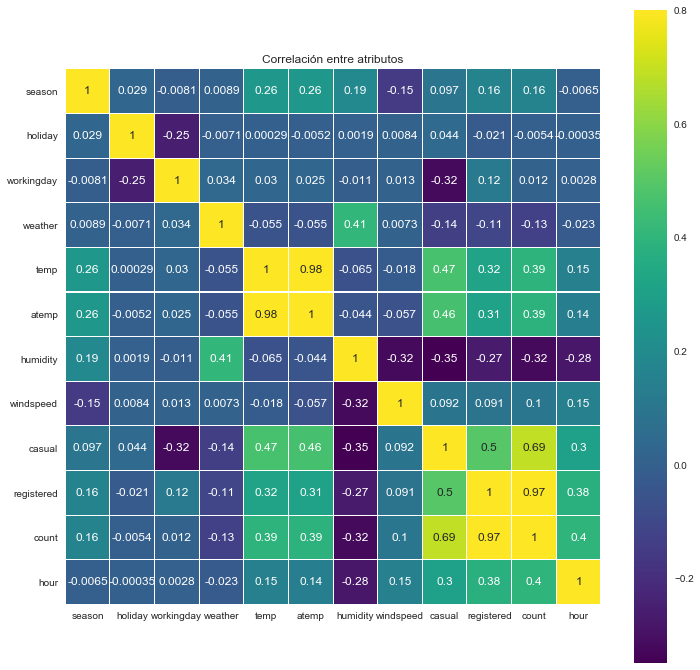

In [51]:
import seaborn as sns

plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
sns.set(font_scale=1)
plt.title('Correlación entre atributos');
plt.show()
sns.reset_orig()

Como es de esperar, la temperatura y la sensación térmica, denotados por `temp` y `atemp` respectivamente, están muy correlacionadas entre sí, con un factor de 0.98. Luego, la correlación entre `registered` y `count` también es muy fuerte, con 0.97. Le sigue `casual` y `count` con 0.69. `registered` y `casual` también se correlacionan, con un factor de 0.5. Una correlación interesante es entre `casual` y ambas `temp` y `atemp`, lo que sugiere que cuando la temperatura era "agradable", entonces la cantidad de usuarios casuales aumentaba.

También existen correlaciones negativas, como por ejemplo entre `casual` y `workingday`. Esto siguere que en los días hábiles, la cantidad de arriendos de usuarios casuales era menor, lo cual hace sentido.

#### (b) Entrenamiento de un árbol de regresión para resolver el problema descrito.

Se usarán los parámetros por defecto, esperando un puntaje aproximado de $0.59$.

c:\program files\python35\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


SCORE TEST=0.703388
KAGG EVAL TRAIN =0.028516
KAGG EVAL TEST =0.574239


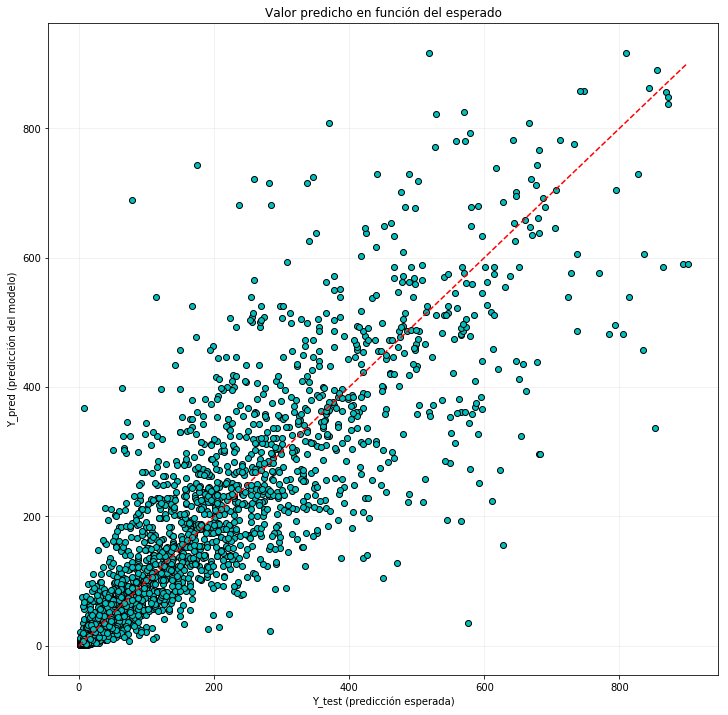

In [52]:
from sklearn.tree import DecisionTreeRegressor as Tree
import matplotlib.pyplot as plt

def eval_bikemodel(y_predict,y_true):
    diff = np.log(y_predict+1.0) - np.log(y_true+1.0)
    return np.sqrt(np.sum(np.square(diff))/len(y_predict))

Xdf=df.ix[:,['season','holiday','workingday','weather','temp','atemp',
        'humidity','windspeed','hour']]
Ydf=df.ix[:,'count']
X_train = Xdf[0:ntrain].values
X_val = Xdf[ntrain:nval].values
X_test = Xdf[nval:].values
Y_train = Ydf[0:ntrain].values
Y_val = Ydf[ntrain:nval].values
Y_test = Ydf[nval:].values

model = Tree(random_state=0)
model.fit(X_train,Y_train)
score_test = model.score(X_test,Y_test)
print ("SCORE TEST=%f"%score_test)

Y_pred_train = model.predict(X_train)
Y_pred_val = model.predict(X_val)
Y_pred_test = model.predict(X_test)
kagg_train = eval_bikemodel(Y_pred_train,Y_train)
kagg_val = eval_bikemodel(Y_pred_val,Y_val)
kagg_test = eval_bikemodel(Y_pred_test,Y_test)
print ("KAGG EVAL TRAIN =%f"%kagg_train)
print ("KAGG EVAL TEST =%f"%kagg_test)
plt.figure(figsize=(12,12))
plt.grid(alpha=0.2)
plt.plot(Y_test,Y_pred_test,'o', c='c', markeredgecolor='black')
plt.plot(range(0,900), range(0,900), linestyle='--', c='r')
plt.xlabel('Y_test (predicción esperada)')
plt.ylabel('Y_pred (predicción del modelo)')
plt.title('Valor predicho en función del esperado')
plt.show()

En efecto, el puntaje obtenido por el modelo es de 0.57, lo que es mejor que el 0.59 esperado. A pesar de eso, a partir del gráfico se nota que las predicciones están en general, bastante alejadas de lo que se espera. Idealmente, la predicción es igual a lo esperado, por lo que se desea un comportamiento lo más parecido a la *identidad* (línea roja).

#### (c) Mejoramiento del árbol de clasificación anterior a través de la modificación de sus hiperparámetros.

La máxima profundidad se variará entre 1 y 50, mientras que se decidirá el modelo a proponer en base a su rendimiento sobre el conjunto de validación.

In [9]:
kagg_val2 = []
for i in range(1,51):
    model2 = Tree(random_state=0,max_depth=i)
    model2.fit(X_train,Y_train)
    Y_pred_val2 = model2.predict(X_val)
    kagg_val2.append(eval_bikemodel(Y_pred_val2,Y_val))

Y se observa el puntaje obtenido en función de la máxima profundidad.

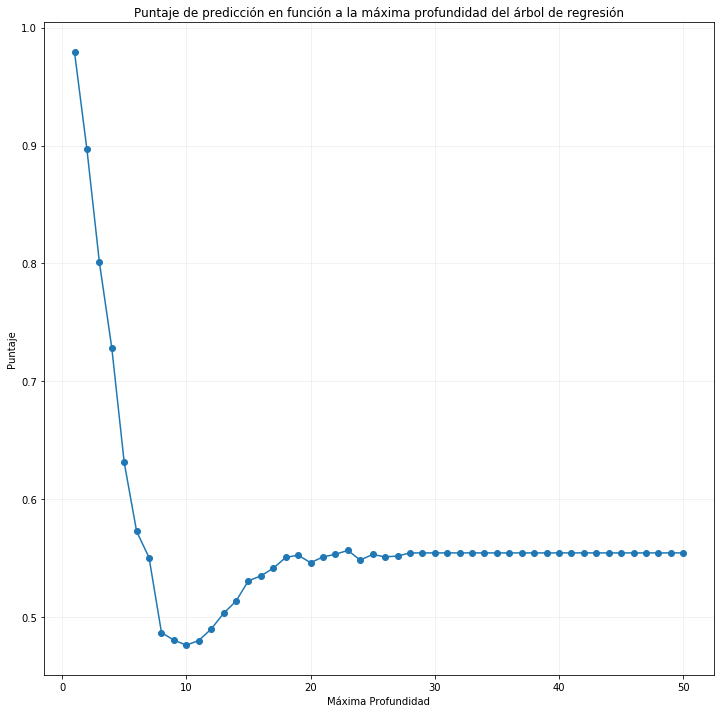

In [18]:
plt.figure(figsize=(12,12))
plt.grid(alpha=0.2)
plt.plot(range(1,51), kagg_val2, marker='o', label='Puntaje')
plt.title('Puntaje de predicción en función a la máxima profundidad del árbol de regresión')
plt.xlabel('Máxima Profundidad')
plt.ylabel('Puntaje')
plt.show()

Se observa que el menor error de validación se encuentra cuando:

In [15]:
print('Max. Profundidad =', kagg_val2.index(min(kagg_val2))+1)

Max. Profundidad = 10


Y cuyo valor es:

In [21]:
print('Valor error validación mínimo =', round(min(kagg_val2),4))

Valor error validación mínimo = 0.4763


Comprobando el error sobre el conjunto de pruebas:

In [24]:
model2 = Tree(random_state=0,max_depth=10)
model2.fit(X_train,Y_train)
Y_pred_val2 = model2.predict(X_val)
kagg_val2 = eval_bikemodel(Y_pred_val2,Y_val)
Y_pred_test2 = model2.predict(X_test)
kagg_test2 = eval_bikemodel(Y_pred_test2,Y_test)

print('Valor error validación con max_depth=10:', round(kagg_val2,4))
print('Valor error pruebas con max_depth=10:', round(kagg_test2,4))

Valor error validación con max_depth=10: 0.4763
Valor error pruebas con max_depth=10: 0.5164


El cual representa una mejora del 0.5742-0.5164=0.0578 por sobre el árbol con parámetros por defecto. La mejora se produce porque, al limitar la profundidad del árbol, se limita el nivel de sobreajuste a los datos de entrenamiento, pues, de no poner límite, la cantidad de *splits* dividiría el espacio de los datos en muchas regiones, dentro de las cuales habrían menos datos, produciendo un aumento en la varianza, y por lo tanto, perdiendo confiabilidad y representatividad.

#### (d) Mejoramiento del rendimiento del modelo a través de modificaciones al conjunto de datos.